## Predicting Chess Winner With Board End Game

Chess training and Testing data was gathered from this site https://www.ficsgames.org/cgi-bin/download.cgi

Data started out in Portable Game Notation (PGN) and it needed to be converted into a CVS file

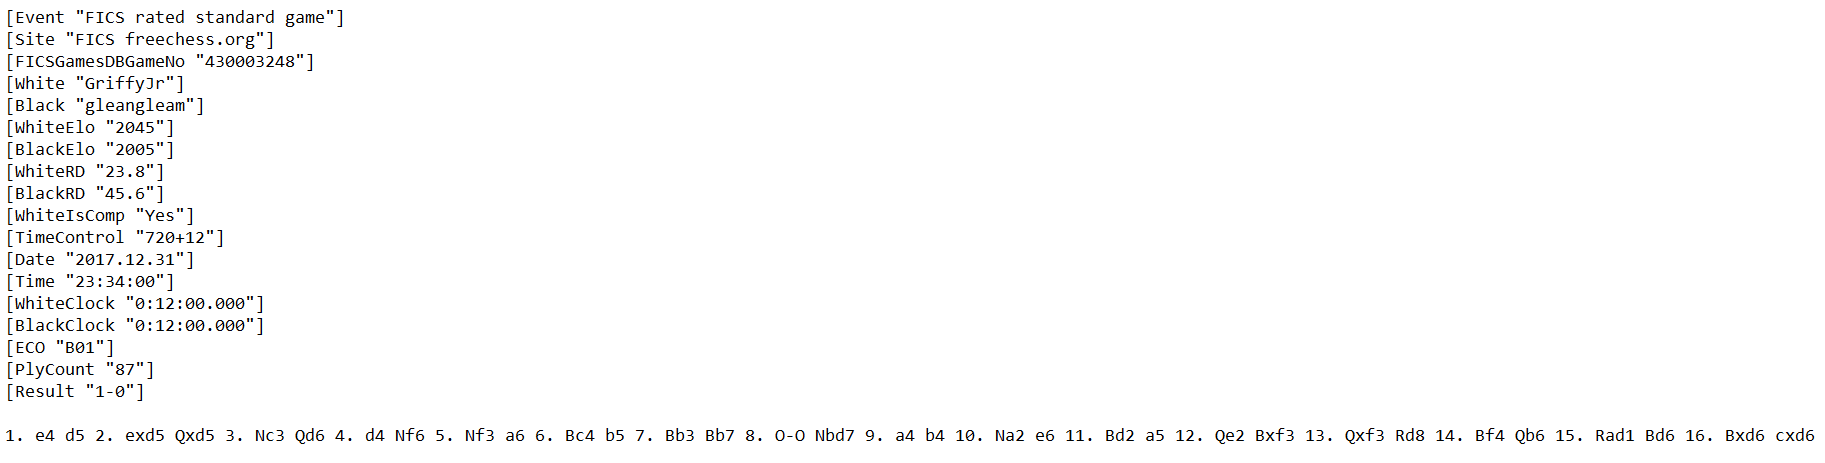

In [1]:
from IPython.display import Image
Image("images/PGN_Format.png")

Used the python library "chess" for it's "pgn" class to get the files contents

Extracted the useful features such as Elo ratings, ratings deviations, turns, moves, victory status, and winner

In [110]:
import chess
import pandas as pd
chess.pgn = open("games2018.pgn")

df = pd.DataFrame(columns = ['white_rating', 'black_rating', 'white_rd','black_rd','turns','winner','moves','victory_status'])
wr=[]
br=[]
wrd=[]
brd=[]
t=[]
w=[]
m=[]
v=[]
i=0
for _ in pgn:
    i+=1
    #Reads each game in the file one at a time an adds them to the correct list
    g=chess.pgn.read_game(pgn)
    if g is not None:
        wr.append(int(g.headers["WhiteElo"]))
        br.append(int(g.headers["BlackElo"]))
        if g.headers["WhiteRD"]!='na':
            wrd.append(float(g.headers["WhiteRD"]))
        if g.headers["BlackRD"]!='na':
            brd.append(float(g.headers["BlackRD"]))
        t.append(int(g.headers["PlyCount"]))
        r=g.headers["Result"]
        if r == '1-0':
            r='white'
        elif r == '0-1':
            r='black'
        else:
            r='draw'
        w.append(r)
        #Victory status is written at the end of the moves so it was sliced off and put into a variable
        mo=str(g.mainline_moves())
        s = mo.find("{")
        s=mo[s+2:-2]
        
        m.append(mo[:mo.find("{")])
        v.append(s)



Add the created lists to the dataframe

In [30]:
df['white_rating']=wr
df['black_rating']=br
df['white_rd']=wrd
df['black_rd']=brd
df['turns']=t
df['winner']=w
df['moves']=m
df['victory_status']=v

In [32]:
# df.to_csv(r'chess2018_Part1.csv')
# df.to_csv(r'chess2017_Part1.csv')

In [253]:
df = pd.read_csv("chess2018_Part1.csv")

After some observation, it was clear that some games were cut short without a clear victory so I removed any game that had under ten moves in the "turns" column

There were also games where a person could be winning but run out of time making him a loser. These games were also removed by searching for 'time' in the victory status column. 

In [254]:
for i in range(len(df['turns'])):
    if int(df['turns'][i])<10:
        df = df.drop(i)
    elif not df['victory_status'][i].find('time')==-1:
        df = df.drop(i)


In [255]:
df

,white_rating,black_rating,white_rd,black_rd,turns,winner,moves,victory_status
0,2301,2874,49.7,46.8,82,black,1. c4 Nf6 2. d4 c6 3. Nf3 d5 4. cxd5 cxd5 5. N...,White resigns
1,2632,1449,48.3,179.9,37,white,1. e4 c5 2. Nf3 e6 3. d4 cxd4 4. Nxd4 a6 5. Nc...,Black resigns
2,2515,1935,34.8,40.3,45,white,1. c4 c5 2. Nc3 Nc6 3. e3 e5 4. Nf3 d6 5. d4 c...,Black resigns
3,2307,2511,57.4,34.8,94,black,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. d3 Be7 5. O-...,White resigns
4,1803,2275,48.6,43.4,64,black,1. e4 e5 2. Bc4 Nf6 3. Nc3 Nxe4 4. Bxf7+ Kxf7 ...,White forfeits by disconnection
...,...,...,...,...,...,...,...,...
78864,2774,2575,34.7,34.9,95,white,1. e4 e5 2. Nf3 Nf6 3. Nxe5 d6 4. Nf3 Nxe4 5. ...,Black resigns
78865,2415,2055,129.2,21.6,80,black,1. Nc3 c5 2. e4 Nc6 3. Nf3 g6 4. d4 cxd4 5. Nx...,White forfeits by disconnection
78866,2057,2403,21.6,132.9,48,black,1. d4 d5 2. c4 e6 3. Nc3 f6 4. e4 dxe4 5. Nxe4...,White resigns
78867,2059,1991,23.8,44.8,122,black,1. d4 d5 2. c4 e6 3. Nf3 Nf6 4. Nc3 c5 5. cxd5...,White resigns


To help the models know what and where board pieces are within games I decided to create synthetic features with each one representing a single spot on the board

There are 64 places in total from A-H 1-8 

Within each column will be a string value that either says what piece is there and what color it is. Or 'None' if empty

Using the same class that I read the PGN files with, I can create a chess game object that will allow me to map out what peice is where on the board. 

The get_pieces method below will look at every spot on the game board object and identify what peice is where.

It puts what it finds in a list and returns once all spots have been viewed

In [256]:
def get_pieces(board):
    board_spots=[]
    #The imported lib identifies wight pecies with capitol letters and black with lower letters so I use a dictionary for classifiacation
    piece_val={'P':'w_pawn', 'N':'w_knight', "B":'w_bishop', "R":'w_rook',"Q":'w_queen',"K":'w_king','p':'b_pawn', 'n':'b_knight', "b":'b_bishop', "r":'b_rook',"q":'b_queen',"k":'b_king'}
    letters=['A','B','C','D','E','F','G','H']
    numbers=['1','2','3','4','5','6','7','8']
    b=[]  
    for l in letters:
        for num in numbers:
            spot=board.piece_at(eval("chess."+(l+num)))            
            if spot != None:                
                b.append(piece_val[str(spot)])                
            else:
                b.append('None')
    return b

The code below will grab every row of moves and push each move that was made to the chess board object until the end game is created and then the game object is submitted to the class above have the pieces identified.

This will keep going until all games have been mapped out

In [258]:
board_spots=[]        
for i in range(len(df['moves'])):
    board = chess.Board()
    a_list = df['moves'].array[i].split()
    for m in a_list:
        if m[0].isalpha():            
            board.push_san(m)
    s = get_pieces(board)
    board_spots.append(s)       

With the identified pieces, then create the 64 columns for the data to be placed into

In [ ]:
cols = [[] for i in range(64)]

#64
for n in range(len(board_spots[0])):    
    for x in range(len(board_spots)):        
        cols[n].append(board_spots[x][n])

Then the columns are added to the dataframe with proper labling of positions

In [ ]:
letters=['A','B','C','D','E','F','G','H']
numbers=['1','2','3','4','5','6','7','8']
i=0
for l in letters:
    for num in numbers:
        df[str(l+num)]=cols[i]
        i+=1

In [ ]:
df.pop('moves')

In [259]:
# df = pd.read_csv("chess2018_Part2.csv")
df

,white_rating,black_rating,white_rd,black_rd,turns,winner,victory_status,A1,A2,A3,...,G7,G8,H1,H2,H3,H4,H5,H6,H7,H8
0,2301,2874,49.7,46.8,82,black,White resigns,None,w_pawn,None,...,None,b_rook,w_king,None,w_pawn,None,None,None,None,None
1,2632,1449,48.3,179.9,37,white,Black resigns,None,w_pawn,None,...,None,b_rook,None,w_pawn,None,None,None,None,b_pawn,None
2,2515,1935,34.8,40.3,45,white,Black resigns,w_rook,None,w_pawn,...,None,None,None,w_pawn,None,None,None,None,b_pawn,b_king
3,2307,2511,57.4,34.8,94,black,White resigns,None,None,None,...,None,None,None,w_pawn,None,None,b_pawn,b_king,None,None
4,1803,2275,48.6,43.4,64,black,White forfeits by disconnection,None,None,w_pawn,...,None,None,None,None,None,None,w_pawn,b_king,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73393,2774,2575,34.7,34.9,95,white,Black resigns,None,None,None,...,None,None,None,w_pawn,None,None,b_pawn,None,b_king,None
73394,2415,2055,129.2,21.6,80,black,White forfeits by disconnection,None,None,None,...,None,None,None,None,None,w_pawn,b_pawn,None,None,None
73395,2057,2403,21.6,132.9,48,black,White resigns,None,w_pawn,b_rook,...,b_pawn,None,None,w_pawn,None,None,None,None,None,b_rook
73396,2059,1991,23.8,44.8,122,black,White resigns,None,None,None,...,None,None,w_king,None,None,None,None,None,None,None


In [2]:
import pandas as pd
import numpy as np

In [40]:
# df.to_csv(r'chess2017_Part2.csv')

In [ ]:
# df = pd.read_csv("chess2018_Part2.csv")

In [243]:
X=df

In [ ]:
# X.to_csv(r'chess2018_preped.csv')

Remove no longer needed features

In [244]:
X = X.drop(['victory_status'], axis=1)
X = X.drop(['turns'], axis=1)
X = X.drop(['moves'], axis=1)

In [245]:
X

,white_rating,black_rating,white_rd,black_rd,winner,A1,A2,A3,A4,A5,...,G7,G8,H1,H2,H3,H4,H5,H6,H7,H8
0,1998,2052,45.2,23.8,black,None,b_rook,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2045,2005,23.8,45.6,white,None,None,None,None,None,...,None,None,None,w_pawn,None,None,None,None,b_pawn,None
2,1995,2067,46.0,21.6,white,None,None,None,None,None,...,None,b_king,None,None,w_pawn,None,None,w_queen,b_pawn,None
3,1790,2778,81.8,34.9,black,None,None,None,None,None,...,None,None,None,None,None,None,None,w_rook,None,None
4,2060,2002,21.6,46.3,white,w_rook,w_pawn,None,None,None,...,None,b_king,None,None,None,None,b_pawn,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81552,2416,1675,0.0,0.0,white,None,w_pawn,None,b_pawn,None,...,None,None,None,None,None,None,None,None,None,None
81554,2470,2848,0.0,0.0,draw,None,b_rook,None,None,w_pawn,...,b_king,None,None,None,None,None,None,None,None,None
81555,2279,1872,0.0,0.0,white,None,w_pawn,None,None,None,...,None,None,None,None,None,None,None,None,b_rook,None
81556,2416,1667,0.0,0.0,white,w_rook,w_pawn,None,None,None,...,b_pawn,b_king,None,w_pawn,None,None,None,None,b_pawn,None


Now the newly created feautres have to be put through one hot encoding since they are categorial

In [ ]:
letters=['A','B','C','D','E','F','G','H']
numbers=['1','2','3','4','5','6','7','8']
pieces=['w_pawn','w_king','w_queen','w_bishop','w_rook','w_knight','b_pawn','b_king','b_queen','b_bishop','b_rook','b_knight','None']

for l in letters:
    for num in numbers:
        #does one hot encoding for every column
        X = pd.get_dummies(X, columns=[l+num], prefix = [l+num])
        for p in pieces:
            #This bit below is important because if a peice was never found on a certain spot then it would not be added as a feature
            #It would fail if a game came along with a move combination that it never had seen before
            if l+num+"_"+p not in X:
                X[l+num+'_'+p]=0


In [1]:
# X.to_csv(r'chess2017_Part3.csv')

In [188]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

In [206]:
X=pd.read_csv("chess2017_Part3.csv")
df = pd.read_csv("chess2017_Part3.csv")

In [207]:
X

,white_rating,black_rating,white_rd,black_rd,winner,A1_None,A1_b_bishop,A1_b_king,A1_b_knight,A1_b_queen,...,H8_b_knight,H8_b_queen,H8_b_rook,H8_w_bishop,H8_w_king,H8_w_knight,H8_w_queen,H8_w_rook,H8_w_pawn,H8_b_pawn
0,1998,2052,45.2,23.8,black,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2045,2005,23.8,45.6,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1995,2067,46.0,21.6,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1790,2778,81.8,34.9,black,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2060,2002,21.6,46.3,white,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76210,2416,1675,0.0,0.0,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76211,2470,2848,0.0,0.0,draw,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76212,2279,1872,0.0,0.0,white,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76213,2416,1667,0.0,0.0,white,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


11.381538461538465
White is 11.38% more likely to win


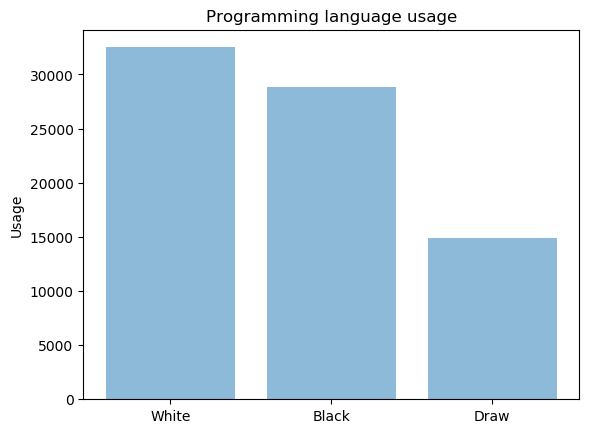

In [244]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('White', 'Black', 'Draw')
y_pos = np.arange(len(objects))
performance = [y.value_counts()[0],y.value_counts()[1],y.value_counts()[2]]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
print((1-y.value_counts()[1]/y.value_counts()[0])*100)
print("White is 11.38% more likely to win")
plt.show()

Now the data can be preped for the models

In [192]:
from sklearn.model_selection import train_test_split

In [193]:
y=X.pop("winner")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [194]:
y

0        black
1        white
2        white
3        black
4        white
         ...  
76210    white
76211     draw
76212    white
76213    white
76214    white
Name: winner, Length: 76215, dtype: object

## First a Decision Tree Classifier is used to find what features are most important

In [8]:
from sklearn.tree import DecisionTreeClassifier
from pandas import Series,DataFrame
import numpy as np
%matplotlib inline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV

Have to model be traied on predicting if white wins or loses

In [9]:
y_train_W = (y_train == "white")
y_test_W = (y_test == "white")

In [10]:
dt1 = DecisionTreeClassifier(random_state=42)
dt1.fit(X_train, y_train_W)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [11]:
cross_val_score(dt1, X_train, y_train_W, cv=3, scoring="accuracy")

array([0.73138776, 0.73052916, 0.72934825])

In [12]:
from sklearn.metrics import roc_curve, auc
y_pred = dt1.predict(X_test)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_W, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.7237754995671807

Calculate feature importance

In [13]:
from sklearn.tree.export import export_graphviz
from io import StringIO

importances = dt1.tree_.compute_feature_importances(normalize=False)
# print("feature importances = " + str(importances))

In [14]:
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]
(range(X.shape[1]), X.columns[indices][:20])


(range(0, 836),
 Index(['black_rating', 'white_rating', 'white_rd', 'black_rd', 'F7_b_pawn',
        'B2_w_pawn', 'F2_w_pawn', 'G2_w_pawn', 'G7_b_pawn', 'G1_w_king',
        'F3_None', 'E2_None', 'E8_None', 'H8_None', 'C8_None', 'F8_None',
        'H2_w_pawn', 'D8_None', 'D5_None', 'D2_None'],
       dtype='object'))

In [238]:
arr=[]
for i in range(len(df["G7_b_pawn"])):
    
    if df["F7_b_pawn"][i]==0:
        arr.append(df["winner"][i])

23.818015745291632
 If a black pawn is not on F7, white is 12.43% more more likely to win


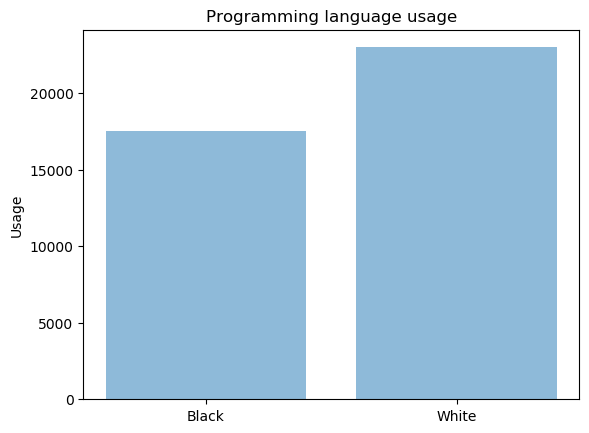

In [247]:
# arr.count('white')
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('Black', 'White')
y_pos = np.arange(len(objects))
performance = [arr.count('black'),arr.count('white')]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
print((1-arr.count('black')/arr.count('white'))*100)
print(" If a black pawn is not on F7, white is 12.43% more more likely to win")
plt.show()

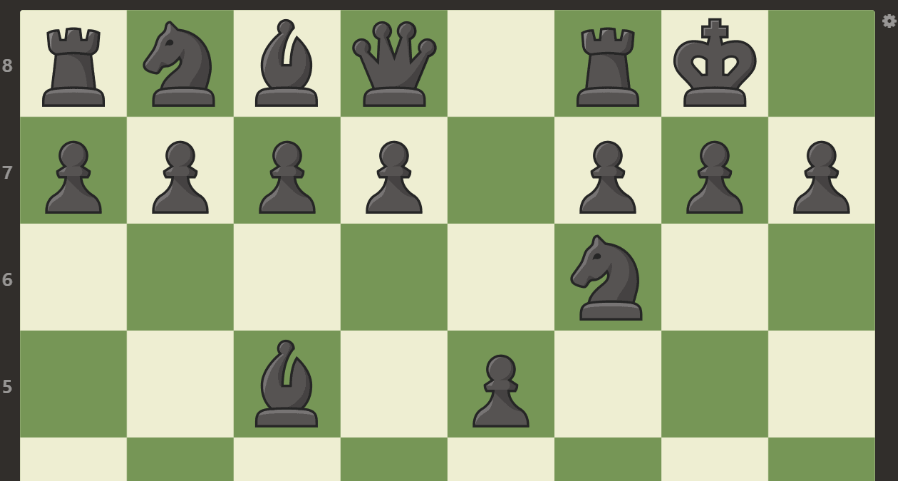

In [250]:
Image("images/Black_Opening.png")

Scale the data for better accuracy

In [15]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

# SGD Classifier

Now the stochastic gradient descent classifier is used to learn and predict the data

In [73]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

sgd_clf = SGDClassifier(random_state=43, eta0=0.1)

sgd_clf.fit(X_train_std, y_train_W)

y_train_pred = cross_val_predict(sgd_clf, X_train_std, y_train_W, cv=3)

confusion_matrix(y_train_W, y_train_pred)

y_test_pred = sgd_clf.predict(X_test_std)

confusion_matrix(y_test_W, y_test_pred)

from sklearn.metrics import accuracy_score, precision_score, recall_score

print("Accuracy score: ", (accuracy_score(y_test_W, y_test_pred)))
print("Precision score: ", (precision_score(y_test_W, y_test_pred)))
print("Recall score: ", (recall_score(y_test_W, y_test_pred)))

y_pred = sgd_clf.predict(X_test_std)
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test_W, y_test_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

Accuracy score:  0.8776295648370872
Precision score:  0.8566761943650469
Recall score:  0.8575516043327203


0.8751019738920272

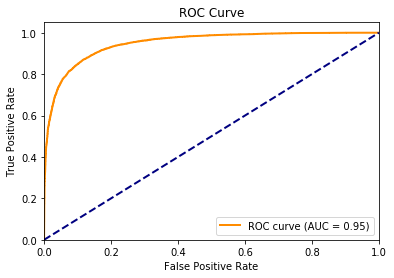

In [74]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
y_test_5_scores = sgd_clf.decision_function(X_test_std)

fpr, tpr, thresholds = roc_curve(y_test_W, y_test_5_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Keras Neural Network

Now the keras neural network is used to learn and predict the data

In [ ]:
from keras.datasets import mnist
from keras.utils import np_utils

In [ ]:
X_flat_train = X_train_std
X_flat_test = X_test_std

Prepare target values using 1-hot encoding

In [ ]:
y_encoded_test = pd.get_dummies(y_test, columns=[0], prefix = ['Winner'])
y_encoded_train = pd.get_dummies(y_train, columns=[0], prefix = ['Winner'])

In [ ]:
y_encoded_test

build a one layer dense network

In [ ]:
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Activation


building a linear stack of densely connected layers with the sequential model from keras

In [ ]:
model = Sequential()

model.add(Dense(512, input_shape=(836,)))
model.add(Activation('relu'))                            

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(3))
model.add(Activation('softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
model.fit(X_flat_train, y_encoded_train,
          batch_size=128, epochs=10,
          verbose=2,
          validation_data=(X_flat_test, y_encoded_test))

In [ ]:
loss_and_metrics = model.evaluate(X_flat_test, y_encoded_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])

SVG had an accuracy score of 87.9% in compairison to the keras 80%

However, I only did a true and false prediction for the SVG on whether or not it thinks white one meaning that it could be correct even if the game was a draw

The Keras model was asked to predict if the game was either white victory, black victory, or a draw which cause more mistakes

-------

#### I created the bit below for personal testing of the models

This class will build the test you give it similar to the dataframe used above

In [75]:
y_boards=[]


def get_pieces(board):
    board_spots=[]
    piece_val={'P':'w_pawn', 'N':'w_knight', "B":'w_bishop', "R":'w_rook',"Q":'w_queen',"K":'w_king','p':'b_pawn', 'n':'b_knight', "b":'b_bishop', "r":'b_rook',"q":'b_queen',"k":'b_king'}
    letters=['A','B','C','D','E','F','G','H']
    numbers=['1','2','3','4','5','6','7','8']
    b=[]
    
    for l in letters:
        for num in numbers:        
            spot=board.piece_at(eval("chess."+(l+num)))            
            if spot != None:              
                b.append(l+num+'_'+piece_val[str(spot)])            
            else:
                b.append(l+num+'_'+"None")
    return b

def custom_builder(wel,bel,wrd,brd,m):
    letters=['A','B','C','D','E','F','G','H']
    numbers=['1','2','3','4','5','6','7','8']
    pieces=['None','w_pawn','w_king','w_queen','w_bishop','w_rook','w_knight','b_pawn','b_king','b_queen','b_bishop','b_rook','b_knight']
    
    y_boards.clear()
    df = pd.DataFrame()

    for col in X.columns:
        df[col] = 0
    
    df['white_rating']=wel
    df['black_rating']=bel
    df['white_rd']=wrd
    df['black_rd']=brd
            
    for l in letters:
        for num in numbers:
            for p in pieces:
                df[l+num+'_'+p]=0

    df['moves']=m
    
    board_spots=[]
    for i in range(len(df['moves'])):
        board = chess.Board()
        a_list = df['moves'][i].split()
        for m in a_list:
            if m[0].isalpha():

                board.push_san(m)
        s = get_pieces(board)
        board_spots.append(s)

        y_boards.append(board)

    cols = [ [] for i in range(64) ]

    #64
    for n in range(len(board_spots[0])):
        #1
        for x in range(len(board_spots)):
            cols[n].append(board_spots[x][n])
    i=0    
    for l in letters:
        for num in numbers:
            for p in pieces:
                df[str(cols[i][0])]=1
            i+=1
    df.pop('moves')    
    return df


I used Magnus games for other examples at this site

https://www.chess.com/games/magnus-carlsen

You can pick any game and then get an analysis on it which will display the moves for the game which I copy and paste into the variable below

In [101]:
Game_PGN = '''
1. 
c4
 
Nf6
 2. 
g3
 
c6
 3. 
Bg2
 
d5
 4. 
b3
 
e5
 5. 
cxd5
 
cxd5
 6. 
Bb2
 
Nc6
 7. 
Nf3
 
Bd6
 8. 
O-O
 
O-O
 9. 
d3
 
Be6
 10. 
Nbd2
 
Rc8
 11. 
b4
 
a6
 12. 
a3
 
Nd7
 13. 
Rc1
 
Qe7
 14. 
Nb3
f6
 15. 
Nfd2
 
b5
 16. 
e3
 
Nb6
 17. 
Ba1
 
Na4
 18. 
d4
 
e4
 19. 
Nxe4
 
dxe4
 20. 
d5
 
Nxb4
 21. 
axb4
 
Rxc1
 22. 
Nxc1
 
Bf7
 23. 
Qc2
 
Bxd5
 24. 
Rd1
 
Bb7
 25. 
Ne2
 
Bxb4
26. 
Qb3+
 
Kh8
 27. 
Nf4
 
Bd6
 28. 
h4
 
Nc5
 29. 
Qb1
 
Bxf4
 30. 
gxf4
 
Nd3
 31. 
Bd4
 
h6
 32. 
Qa1
 
Rc8
 33. 
Qa2
 
b4
 34. 
Qa5
 
Qe6
 35. 
Qh5
 
Rc7
 36. 
f5
 
Qf7
 37. 
Qg4
 
Rc2
38. 
Rf1
 
h5
 39. 
Qg3
 
b3
 40. 
Qb8+
 
Kh7
 41. 
Qa7
 
Qc7
 42. 
Bb6
 
Qc6
 
 
 
 
'''

In [102]:
def predictWinner():
    print("SGD predicts: ")
    if y_pred[0]:
        print("white wins")
    else:
        print("black wins or draw")
    print("")
    print("Keras predicts: ")
    print(y[model.predict_classes(custom_tests_std, batch_size=32, verbose=0)[0]]+" wins")    

I give them the same Elo and RD score so it only is dependent on the pieces

In [112]:
import chess
from IPython.display import Image
custom_tests=custom_builder([2000],[2000],[20],[20],[Game_PGN])

# custom_tests["C6_b_queen"]=0
# custom_tests["C6_None"]=1


custom_tests_std = sc.transform(custom_tests)
y_pred = sgd_clf.predict(custom_tests_std)

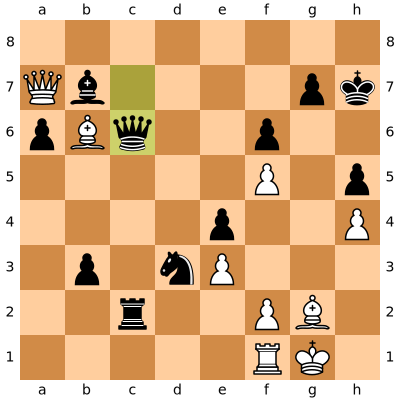

In [113]:
y_boards[0]

In [114]:
predictWinner()

SGD predicts: 
black wins or draw

Keras predicts: 
black wins


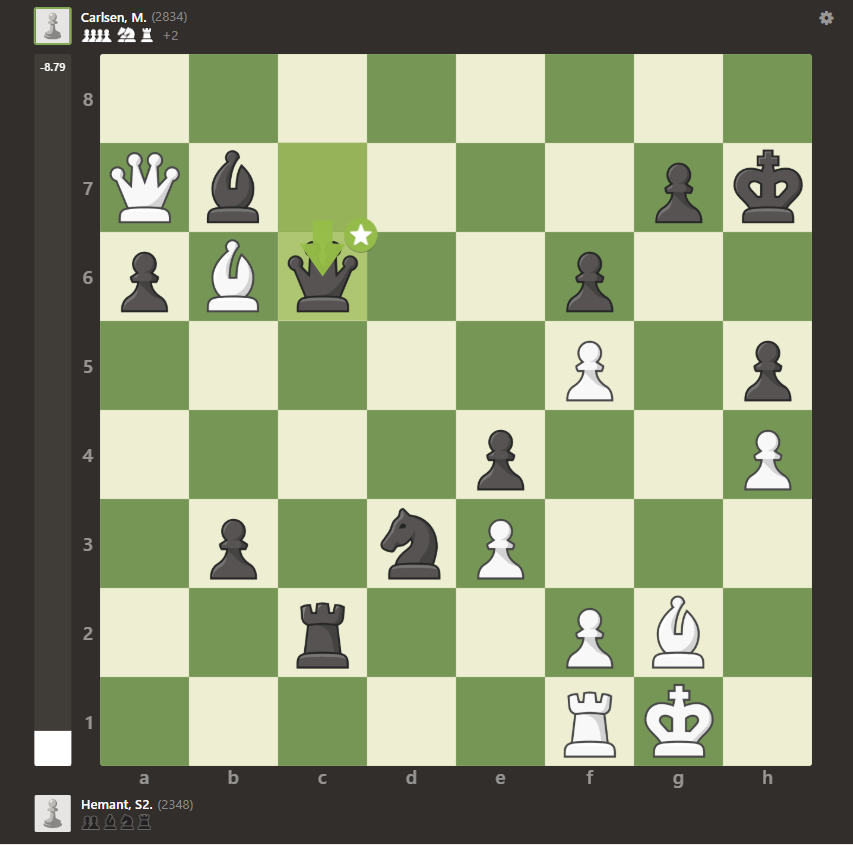

In [115]:
Image("images/Black_Win.png")

In [116]:
Game_PGN = '''

1. 
e4
 
e5
 2. 
Nf3
 
Nf6
 3. 
Nxe5
 
d6
 4. 
Nf3
 
Nxe4
 5. 
Nc3
 
Nxc3
 6. 
dxc3
 
Be7
 7. 
Be3
 
Nc6
 8. 
Bd3
 
Be6
 9. 
Qe2
 
Bf6
 10. 
O-O-O
 
Qe7
 11. 
Kb1
 
a6
 12. 
Rhe1
 
O-O-O
 13. 
h3
 
Rhe8
 14. 
g4
 
h6
 15. 
Nd2
 
Bg5
 16. 
f4
 
Bh4
 17. 
Bf2
 
Bxf2
 18. 
Qxf2
 
Qf8
 19. 
f5
 
Bd7
 20. 
f6
 
g6
 21. 
Be4
 
Kb8
 22. 
Nc4
 
Re6
 23. 
Bxc6
 
Rxe1
 24. 
Rxe1
 
Bxc6
 25. 
Na5
 
Re8
 26. 
Nxc6+
 
bxc6
 27. 
Qg3
 
Qh8
 28. 
Re7
 
Rxe7
 29. 
fxe7
 
Qe8
 30. 
Qe3
 
Kc8
 31. 
h4
 
Kd7
 32. 
Qxh6
 
Qxe7
 33. 
b3
 
Qe4
 34. 
g5
 
Qe5
 35. 
Qf8
 
Qd5
 36. 
Kb2
 
c5
 37. 
Qg8
 
Qf3
 38. 
Qf8
 
Qd5
 39. 
Qg7
 
Qf5
 40. 
Qg8
 
Qf3
 41. 
a4
 
Qf1
 42. 
Qf8
 
Qf5
 43. 
Qa8
 
Qf1
 44. 
Qe4
 
Kd8
 45. 
Qg4
 
d5
 46. 
a5
 
Qe1
 47. 
h5
 
gxh5
 48. 
Qxh5
 
Qe6
 49. 
Qh8+
 
Ke7
 50. 
b4
 
cxb4
 51. 
cxb4
 
Kd7
 52. 
Qd4
 
Kc8
 53. 
Qf6
 
Qxf6+
54. 
gxf6
 
Kd7
 55. 
Kb3
 
Kc6
 56. 
c4
 
d4
 57. 
Kc2
 
Kd6
 58. 
Kd2
 
c6
 59. 
Ke2
 
Kd7
 60. 
Kd3
 
Kc7
 61. 
Kxd4
 
Kd6
 62. 
Kd3
 
Kc7
 63. 
Ke4
 
Kd6
 64. 
Kd4
 '''

In [117]:
custom_tests=custom_builder([2000],[2000],[20],[20],[Game_PGN])

# custom_tests["C3_w_bishop"]=0

custom_tests_std = sc.transform(custom_tests)
y_pred = sgd_clf.predict(custom_tests_std)

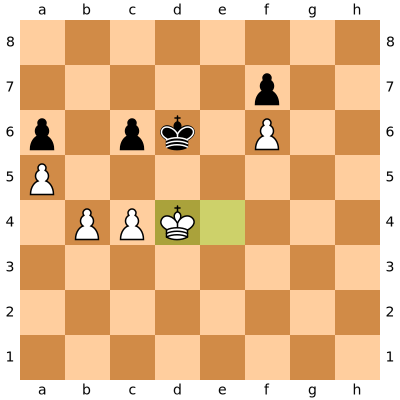

In [118]:
y_boards[0]

In [119]:
predictWinner()

SGD predicts: 
white wins

Keras predicts: 
white wins


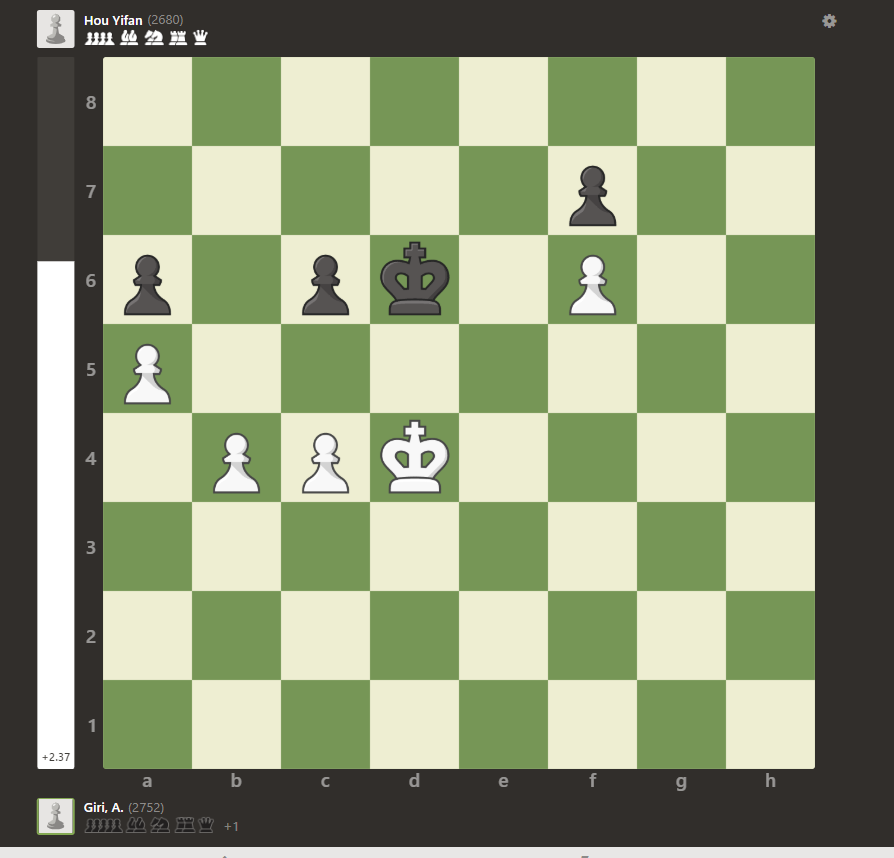

In [120]:
Image("images/White_Win.png")

In [121]:
Game_PGN='''

1. 
e4
 
e5
 2. 
Nf3
 
Nc6
 3. 
Bb5
 
Nf6
 4. 
d3
 
Bc5
 5. 
O-O
 
Nd4
 6. 
Nxd4
 
Bxd4
 7. 
c3
 
Bb6
 8. 
Ba4
 
O-O
 9. 
Bg5
 
d6
 10. 
Nd2
 
h6
 11. 
Bh4
 
Bg4
 12. 
Qe1
 
g5
 13. 
Bg3
 
Nh5
 14. 
Bd1
 
Bxd1
 15. 
Qxd1
 
Ng7
 16. 
Nc4
 
f5
 17. 
exf5
 
Nxf5
 18. 
a4
 
a6
 19. 
Qb3
 
Kh8
 20. 
Nxb6
 
cxb6
 21. 
Rfe1
 
h5
 22. 
f3
 
Nxg3
 23. 
hxg3
 
g4
 24. 
fxg4
 
hxg4
 25. 
Re4
 
Qd7
 26. 
Qxb6
 
Rf7
 27. 
Qe3
 
Qf5
 28. 
Qh6+
 
Kg8
 29. 
Qe3
 
Raf8
 30. 
Qe2
 
Qf2+
 31. 
Qxf2
 
Rxf2
 32. 
Rxg4+
 
Kh7
 33. 
Rb4
 
Rd2
 34. 
Rxb7+
 
Kg6
 35. 
Rf1
 
Rxf1+
 36. 
Kxf1
 
Kf5
 37. 
Rb6
 
Rxd3
 38. 
Rxa6
 
Rd2
 39. 
Rb6
 
e4
 40. 
a5
 
e3
 41. 
Rb4
 
Rf2+
 42. 
Ke1
 
Rxg2
 43. 
Ra4
 
Rxb2
 44. 
a6
 
'''

In [122]:
custom_tests=custom_builder([2000],[2000],[20],[20],[Game_PGN])

# custom_tests["A6_w_pawn"]=0

custom_tests_std = sc.transform(custom_tests)
y_pred = sgd_clf.predict(custom_tests_std)


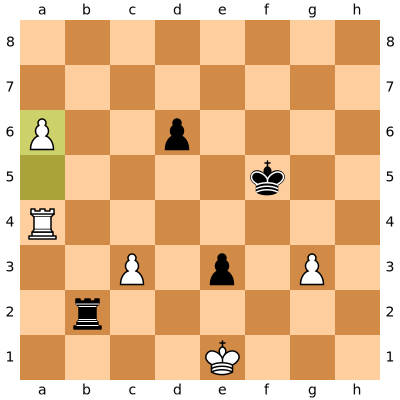

In [123]:
y_boards[0]

In [124]:
predictWinner()

SGD predicts: 
white wins

Keras predicts: 
black wins


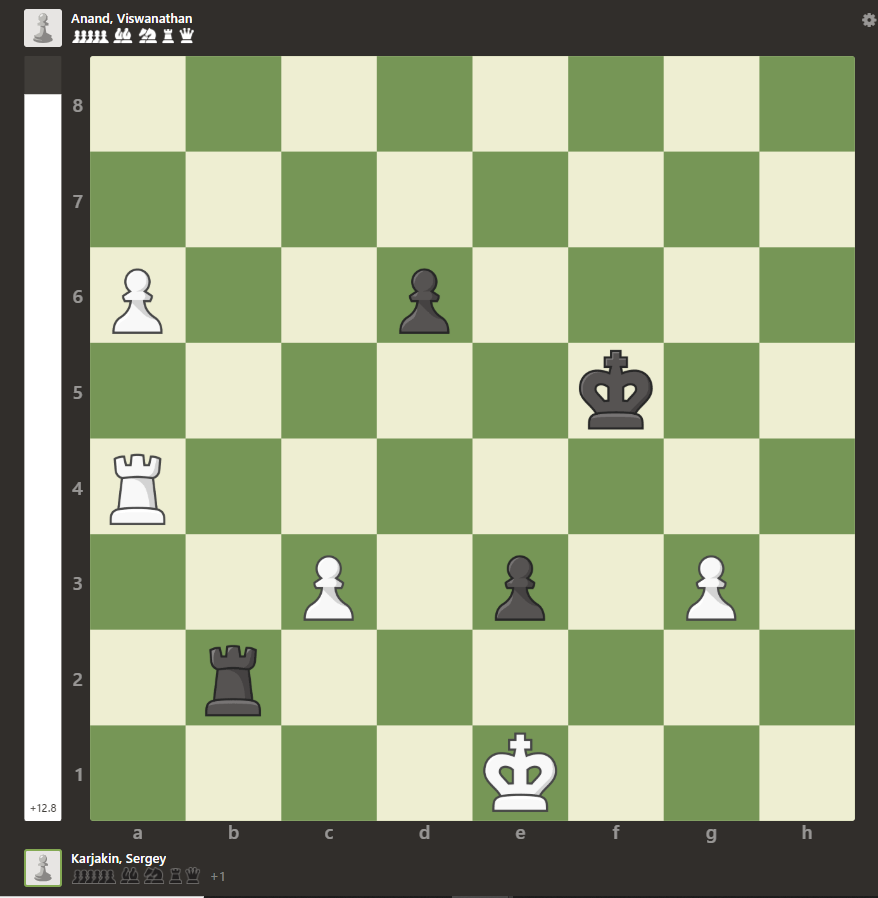

In [125]:
Image("images/White_Win2.png")